# Parametric working memory 
Code for exercise 3

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch_directml
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture 
import dataset.generate_dataset as generate_dataset
import models.neural_networks as neural_networks 
import models.latent_dynamics as latent_dynamics
import evaluation.visualise_dynamics as visualise_dynamics
import evaluation.visualise_connectivity as visualise_connectivity
import matplotlib.colors as mcolors
import scipy 

device = torch_directml.device()
print('Using {}'.format(device))

np.random.seed(0)
torch.manual_seed(2)
list_colors = list(mcolors.TABLEAU_COLORS)

Using privateuseone:0


## 1. Generate data.

200
200


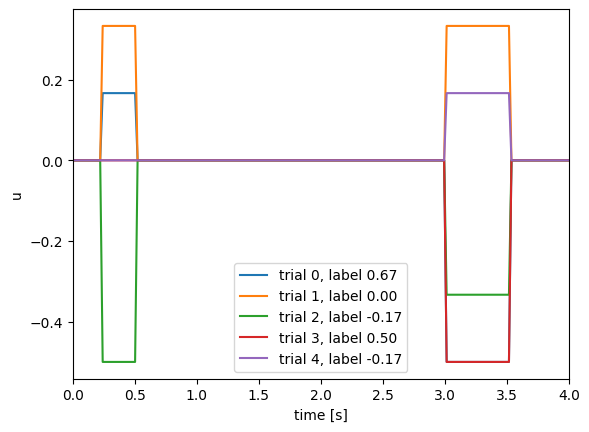

In [2]:
batch_size = 32
num_trials = batch_size * 250
sampling_rate = 1/(20/1000) #[Hz]
t_onsets = np.array([5, 60]) * sampling_rate/1000 # [s]
t_offsets = np.array([10, 70]) * sampling_rate/1000 # [s]
t_max = 4000/1000 # [s]
num_trial_to_plot = 5 # should be less than batch_size
stimulus_strength_list  = np.arange(10, 38, 4)

PWM_dataset_train = generate_dataset.PWMStimulus(num_trials, t_onsets, t_offsets, t_max, stimulus_strength_list, sampling_rate)
PWM_dataset_test = generate_dataset.PWMStimulus(int(num_trials/100), t_onsets, t_offsets, t_max, stimulus_strength_list, sampling_rate)

fig = PWM_dataset_train.plot_stimulus(np.arange(num_trial_to_plot))
plt.show()

0 torch.Size([32, 200]) torch.Size([32])
1 torch.Size([32, 200]) torch.Size([32])
2 torch.Size([32, 200]) torch.Size([32])
3 torch.Size([32, 200]) torch.Size([32])


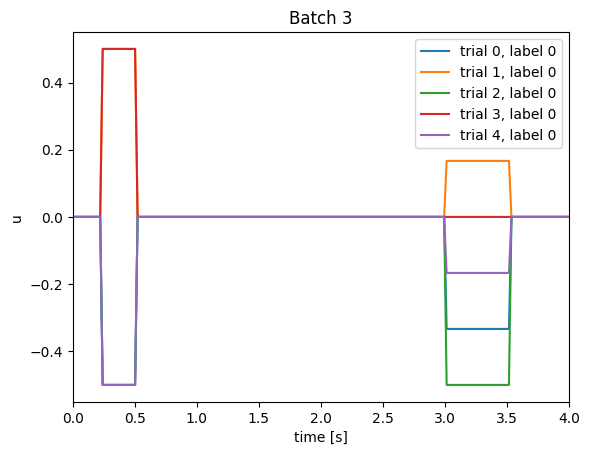

In [3]:
train_dataloader = DataLoader(PWM_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(PWM_dataset_test, batch_size=batch_size, shuffle=True)

# check a batch 
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['stimulus'].size(),
          sample_batched['label'].size())
    
    batch_size = len(sample_batched['stimulus'])
    
    # observe 4th batch and stop.
    if i_batch == 3:
        for i_trial in range(num_trial_to_plot):
            plt.plot(PWM_dataset_train.time, sample_batched['stimulus'][i_trial, :], \
                    label='trial {:d}, label {:d}'.format(int(i_trial), int(sample_batched['label'][i_trial])))
        plt.xlim(0, max(PWM_dataset_train.time))
        plt.xlabel('time [s]')
        plt.ylabel('u')
        plt.legend()
        plt.title('Batch {}'.format(i_batch))
        plt.show()
        break

## 2. Low rank RNN  

In [4]:
input_size = 1
hidden_size = 128
output_size = 1
rank = 2
time_step = 20/1000 # s 
tau = 100/1000 # s
model = neural_networks.LowRankRNN(
    input_size, hidden_size, 
    output_size, rank, 
    time_step, tau).to(device)
print(model)

LowRankRNN(
  (feedforward_input): LinearAmpFactor(in_features=1, out_features=128)
  (recurrent_input): RNNLayer(in_features=128, out_features=128)
  (readout): LinearAmpFactor(in_features=128, out_features=1)
)


Run simulation & Visualise a time course of each hidden node.  

try simulation for the first batch
shape of stimulus:  torch.Size([32, 200])
shape of label: torch.Size([32])


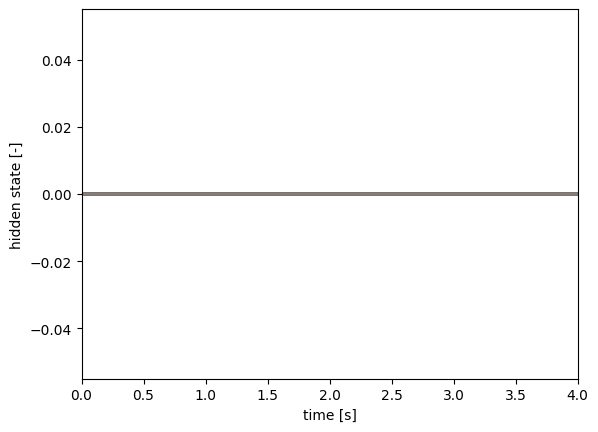

In [5]:
sample_batched = next(iter(train_dataloader))
print('try simulation for the first batch')
print('shape of stimulus: ', sample_batched['stimulus'].size())
print('shape of label:', sample_batched['label'].size())

visualise_dynamics.plot_hidden_nodes_single_trial(
    device, model, t_max, PWM_dataset_train, train_dataloader)

## 3. Train network

In [6]:
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 5e-3
loss_min = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
time_step_for_loss = 5 #[-] not in sec    

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    num_epoches = len(dataloader)
    loss_history = []
    for i_batch, sample_batched in enumerate(dataloader):
        #print(i_batch, sample_batched['stimulus'].size(),
        #      sample_batched['label'].size())      
              
        _batch_size = len(sample_batched['stimulus'])
        hidden_state = model.init_hidden(_batch_size)        
        loss = 0 
        optimizer.zero_grad()
        #print(sample_batched['stimulus'].shape)
        num_sample_points = sample_batched['stimulus'].shape[1]
        
        for i_time in range(num_sample_points):
            #print(sample_batched['stimulus'].shape)
            input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
            label_data = sample_batched['label'].float().to(device)
            hidden_state = hidden_state.to(device)
            output, hidden_state = model(input_data, hidden_state)
            
            if i_time >=(num_sample_points - time_step_for_loss):
                #print(output.shape)
                #print(loss_fn(output.squeeze().to(device), label_data))
                loss += loss_fn(output.squeeze().to(device), label_data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i_batch+1) * _batch_size
        
        if i_batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{num_epoches*_batch_size:>5d}]")
        
        loss_history.append(loss)

    return loss_history 

def test(dataloader, model, loss_fn):
    num_epoches = len(dataloader)
    model.eval()
    test_loss = 0 
    correct = 0
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(dataloader):
            _batch_size = len(sample_batched['stimulus'])
            hidden_state = model.init_hidden(_batch_size)
            num_sample_points = sample_batched['stimulus'].shape[1]
         
            for i_time in range(num_sample_points):
                input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
                label_data = sample_batched['label'].float().to(device)
                hidden_state = hidden_state.to(device)
                output, hidden_state = model(input_data, hidden_state)   
            
            test_loss += loss_fn(output.squeeze().to(device), label_data)
            correct += ((output.sign() * label_data.sign()) == 1).sum().item() / _batch_size

    test_loss /= num_epoches
    correct /= num_epoches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
# train model 
loss_history = train(train_dataloader, model, loss_fn, optimizer)

/home/yota/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


loss: 1.002198  [   32/ 8000]
loss: 0.488703  [ 3232/ 8000]
loss: 0.530095  [ 6432/ 8000]


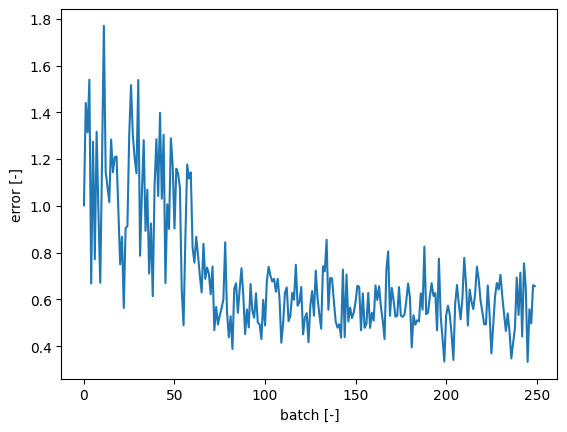

In [9]:
plt.plot(loss_history)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()

Test Error: 
 Accuracy: 64.6%, Avg loss: 0.125475 



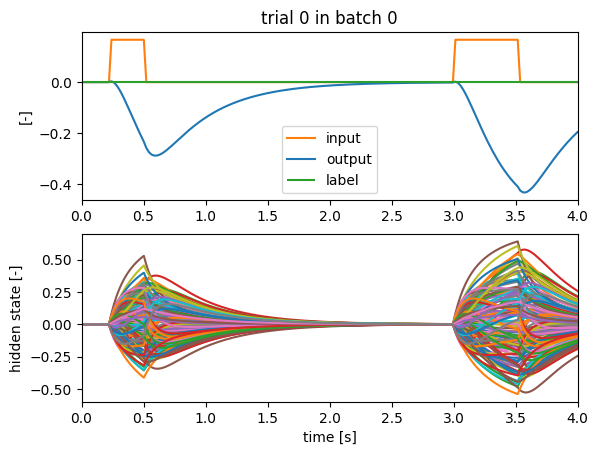

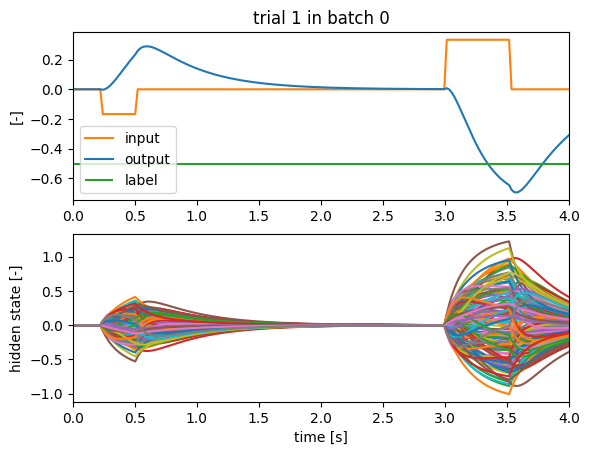

In [12]:
# test model 
test(test_dataloader, model, loss_fn)

# visualise dynamics of trained RNN
visualise_dynamics.plot_dynamics_each_trial(
    
    device, model, t_max, PWM_dataset_test, test_dataloader, num_trial_to_plot=2)